# New York City Taxi Fare Prediction
This notebook is dedicated to practicing the techniques from [fastai chapter 6](https://course.fast.ai/Lessons/lesson6.html) on the [new york taxi fare dataset](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction)

In [51]:
# Install stuff
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastai.vision.all import *
from fastbook import *
import zipfile,kaggle

In [2]:
# Download the data
path = Path('new-york-city-taxi-fare-prediction')
if not path.exists():
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [3]:
import pandas as pd

chunksize = 100000 
chunks = pd.read_csv("new-york-city-taxi-fare-prediction/train.csv", chunksize=chunksize)

chunk_list = []
for chunk in chunks:
    chunk_list.append(chunk)

print(len(chunk_list))

555


In [4]:
chunk_list[0].head(), chunk_list[-1].head()

(                             key  fare_amount          pickup_datetime  \
 0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
 1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
 2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
 3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
 4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   
 
    pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
 0        -73.844311        40.721319         -73.841610         40.712278   
 1        -74.016048        40.711303         -73.979268         40.782004   
 2        -73.982738        40.761270         -73.991242         40.750562   
 3        -73.987130        40.733143         -73.991567         40.758092   
 4        -73.968095        40.768008         -73.956655         40.783762   
 
    passenger_count  
 0                1  
 1                1  
 2          

The data doesn't seem to be ordered as a time series so I think I can just refine my model and data processing using a single chunk and then try training the final model using the full data set.

In [5]:
import random

df = chunk_list[random.randint(1, len(chunk_list))]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 11500000 to 11599999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  100000 non-null  float64
 6   dropoff_latitude   100000 non-null  float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


In [7]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.359691,-72.463964,39.905287,-72.484442,39.914074,1.689320
std,9.846908,10.546691,6.075411,10.705400,6.171480,1.313307
min,-8.500000,-79.016635,-74.012927,-736.383332,-74.016267,0.000000
25%,6.000000,-73.992035,40.735000,-73.991348,40.734178,1.000000
50%,8.500000,-73.981719,40.752719,-73.980059,40.753231,1.000000
75%,12.500000,-73.967022,40.767080,-73.963670,40.768060,2.000000
max,430.000000,40.798667,73.781775,40.817667,412.350000,6.000000


I like this data set so far as their are not a whole lot of columns to deal with.

It looks like there are some missing values in the dropoff location. I'll leave it for now until I take a better look at the data.

In [8]:
from fastai.tabular.all import *

# Add some date-time metadata
train_df = add_datepart(df, 'pickup_datetime')
train_df.info()

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 11500000 to 11599999
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   key                              100000 non-null  object 
 1   fare_amount                      100000 non-null  float64
 2   pickup_longitude                 100000 non-null  float64
 3   pickup_latitude                  100000 non-null  float64
 4   dropoff_longitude                100000 non-null  float64
 5   dropoff_latitude                 100000 non-null  float64
 6   passenger_count                  100000 non-null  int64  
 7   pickup_datetimeYear              100000 non-null  int32  
 8   pickup_datetimeMonth             100000 non-null  int32  
 9   pickup_datetimeWeek              100000 non-null  int32  
 10  pickup_datetimeDay               100000 non-null  int32  
 11  pickup_datetimeDayofweek         100000 non-null  int32 

In [120]:
dep_var = "fare_amount"
cont, cat = cont_cat_split(train_df, 1, dep_var=dep_var)
procs = [Categorify, FillMissing]
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs, cat, cont, y_names=dep_var, splits=splits)

print(f"Training set length: {len(to.train)}")
print(f"Validation set length: {len(to.valid)}")

Training set length: 80000
Validation set length: 20000


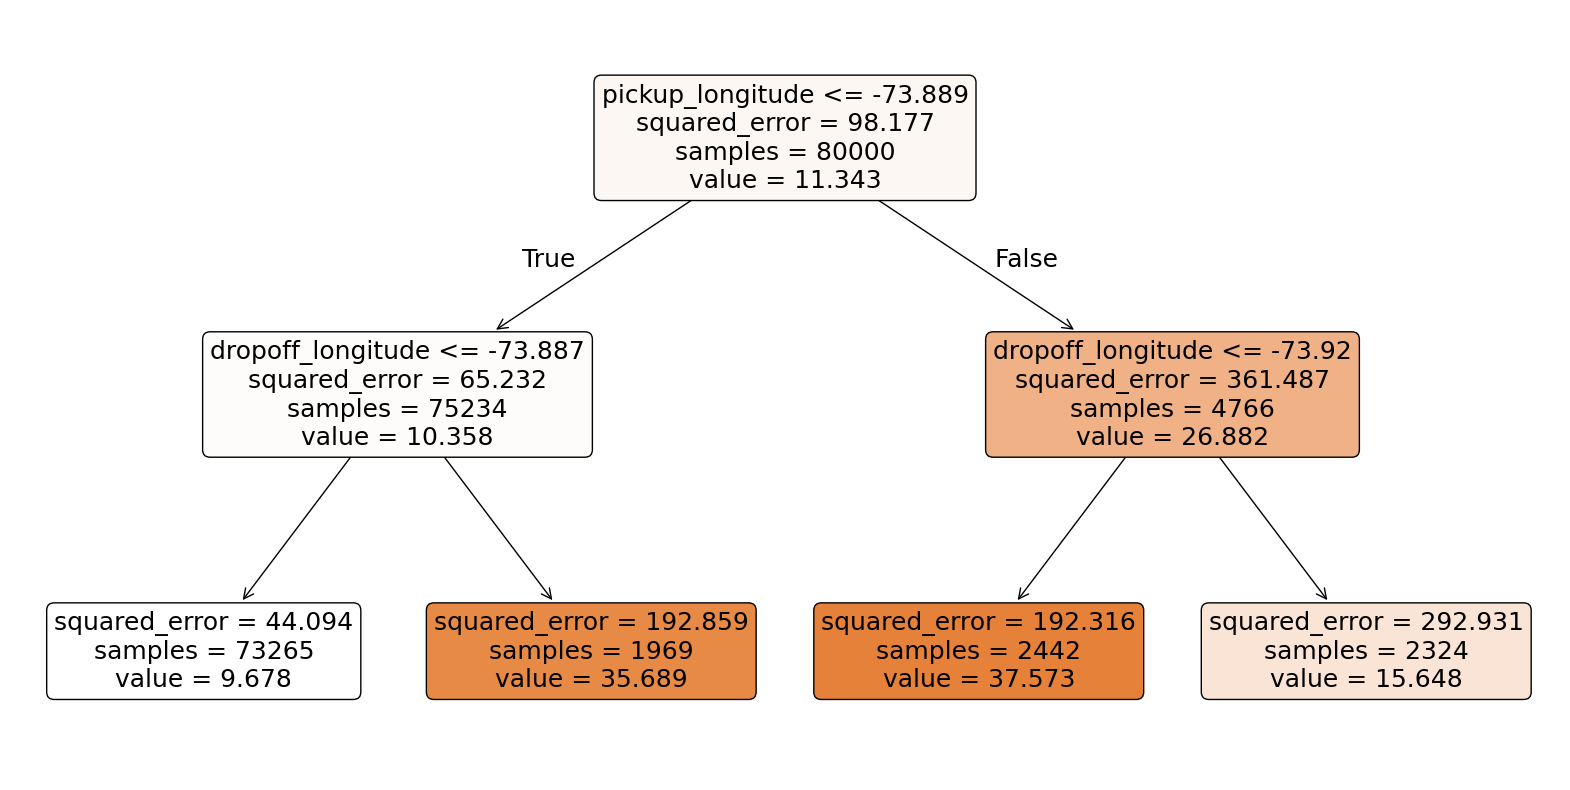

In [121]:
from sklearn.tree import DecisionTreeRegressor

xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

def show_tree(tree, feature_names):
    plt.figure(figsize=(20,10))
    plot_tree(tree, filled=True, rounded=True, feature_names=feature_names)
    plt.show()

show_tree(m, feature_names=xs.columns)

In [12]:
!pip install dtreeviz

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


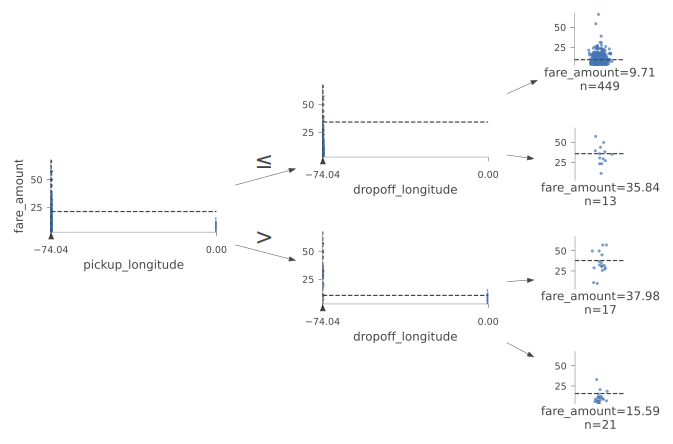

In [13]:
from dtreeviz.trees import *
samp_idx = np.random.permutation(len(y))[:500]

viz_model=model(m,
                         X_train=xs.iloc[samp_idx],
                         y_train=y.iloc[samp_idx],
                         feature_names=xs.columns,
                         target_name=dep_var)

viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')


It looks like there is something weird going on with the pickup_longitude. I'm going to dig into this more but first let's get a baseline accuracy and submission

In [91]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

In [92]:
train_preds = m.predict(xs)
valid_preds = m.predict(valid_xs)
rmse(y, train_preds), rmse(valid_y, valid_preds)

(4.789474371523867, 5.444156746442418)

In [16]:
# Get the test data and process it
test_df = pd.read_csv("new-york-city-taxi-fare-prediction/test.csv")
test_df = add_datepart(test_df, 'pickup_datetime')
to_test = to.train.new(test_df)
to_test.process()
test_xs = to_test.xs

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


### Note
I was running the note book previously and some of the chunks have missing drop off location data. TabularPandas didn't seem to be handling it properly and this was causing an issue with the cell above.

Will dig into this later when I have to train on the whole data set.

## Baseline Submission

In [25]:
test_preds = m.predict(test_xs)
submission = pd.DataFrame({
    'key': test_df['key'],
    'fare_amount': test_preds.round(2)
})
submission.to_csv("submissions/baseline.csv", index=False)
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.71
1,2015-01-27 13:08:24.0000003,9.71
2,2011-10-08 11:53:44.0000002,9.71
3,2012-12-01 21:12:12.0000002,9.71
4,2012-12-01 21:12:12.0000003,9.71


In [26]:
sample_sub = pd.read_csv("new-york-city-taxi-fare-prediction/sample_submission.csv")
sample_sub.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


### First Submission
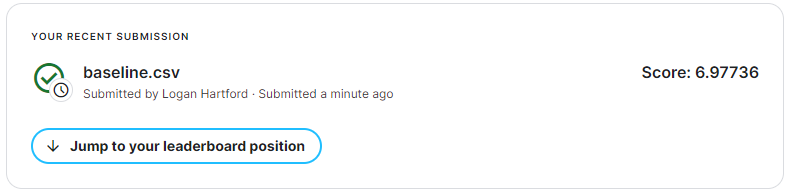

The formatting is right which is good and our score is about what is predicted for a simple distance algorithm. Before digging into the data, lets try a deeper tree and a random forrest to see what we get.

In [122]:
# Save the data
save_pickle(path/'xs.pkl', xs)
save_pickle(path/'y.pkl', y)
save_pickle(path/'valid_xs.pkl', valid_xs)
save_pickle(path/'test_xs.pkl', test_xs)

In [74]:
m = DecisionTreeRegressor(min_samples_leaf=50)
m.fit(xs, y);

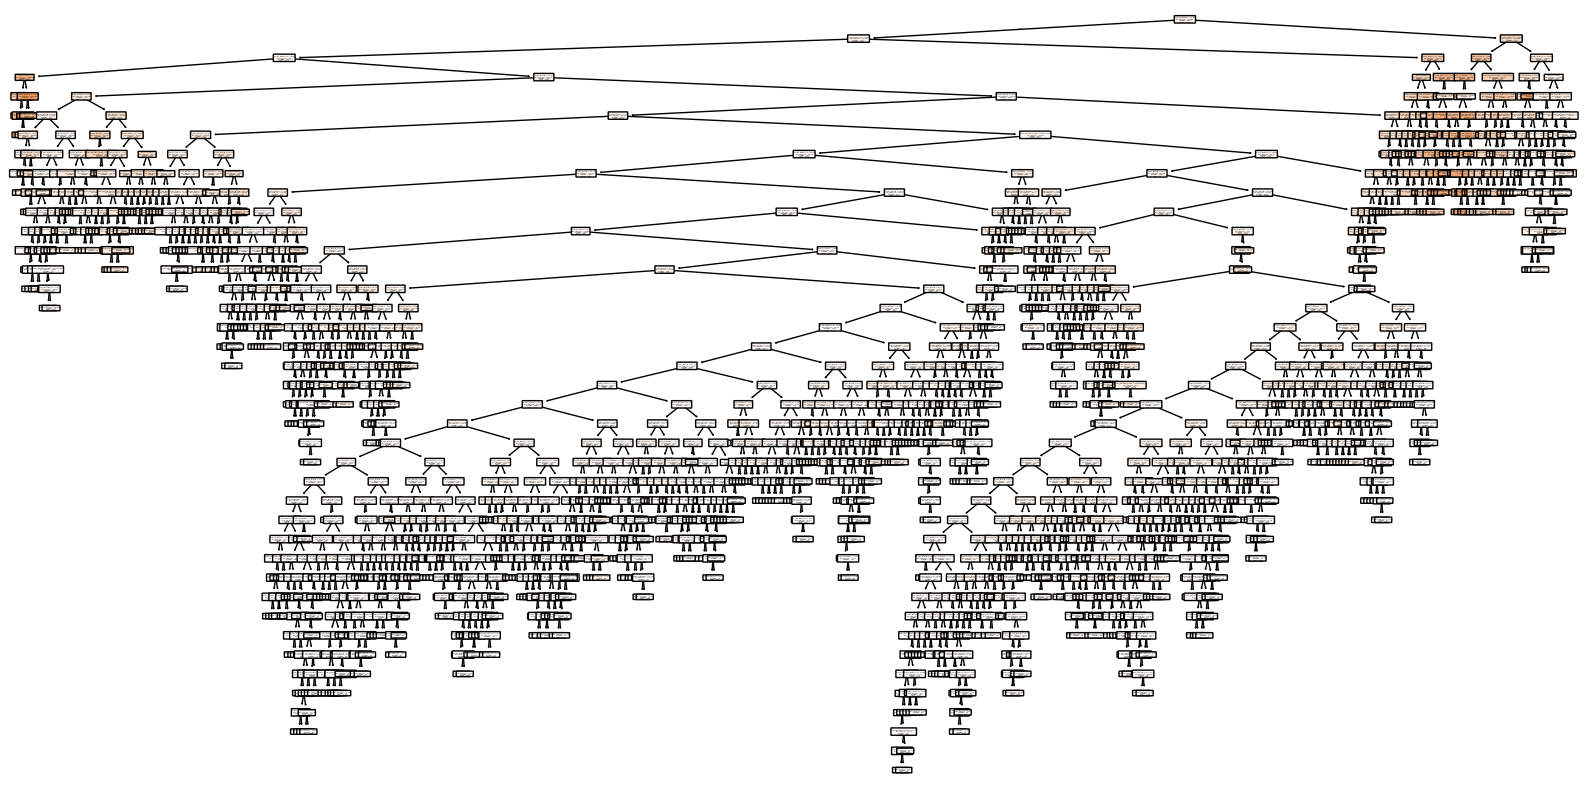

In [75]:
show_tree(m, feature_names=xs.columns)

In [76]:
m.tree_.node_count

2457

In [186]:
def get_metrics(m, xs, valid_xs):
    train_preds = m.predict(xs)
    valid_preds = m.predict(valid_xs)
    return rmse(y, train_preds), rmse(valid_y, valid_preds)

In [95]:
get_metrics(m, xs, valid_xs)

(4.789474371523867, 5.444156746442418)

In [56]:
def generate_submission(m, test_xs, filename):
    test_preds = m.predict(test_xs)
    submission = pd.DataFrame({
        'key': test_df['key'],
        'fare_amount': test_preds.round(2)
    })
    if ".csv" not in filename:
        filename = filename + ".csv"
    filename = "submissions/"+filename
    submission.to_csv(filename, index=False)
    return kaggle.api.competition_submit(file_name=filename, message=filename, competition='new-york-city-taxi-fare-prediction')

In [57]:
generate_submission(m, test_xs, "big_tree")

100%|█████████████████████████| 328k/328k [00:00<00:00, 505kB/s]


Successfully submitted to New York City Taxi Fare Prediction

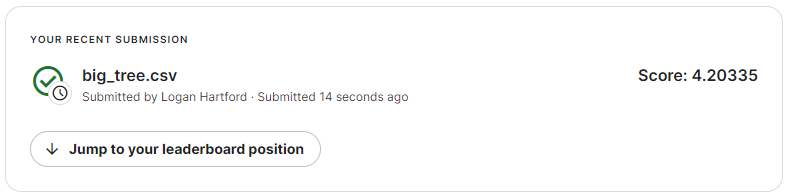

In [64]:
from sklearn.ensemble import RandomForestRegressor

def rf(xs, y, n_estimators=100, max_samples=60000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [96]:
m = rf(xs, y)

In [97]:
get_metrics(m, xs, valid_xs)

(3.820459313237096, 5.1691664252618486)

Our loss is decreasing sharply on the test set but falling off on the validation set. Lets try increasing the size of the training data.

In [98]:
generate_submission(m, test_xs, "random_forest")

100%|█████████████████████████| 328k/328k [00:00<00:00, 490kB/s]


Successfully submitted to New York City Taxi Fare Prediction

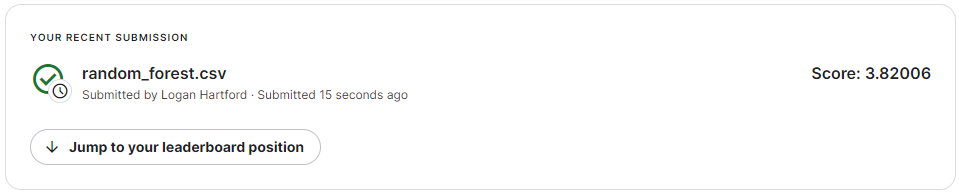
Interestingly, we scored much better on the test set than we did on our own validation set. I'll try increasing the size of the dataset by 10x and see how long training takes and see what impact that has but this will require more data processing because there will be missing values.

In [107]:
random_chunks = random.sample(chunk_list, 10)
ten_chunks_df = pd.concat(random_chunks, ignore_index=True)
ten_chunks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999995 non-null   float64
 6   dropoff_latitude   999995 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


In [108]:
ten_chunks_df[ten_chunks_df['dropoff_latitude'].isna()]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
19318,2012-12-11 12:34:14.0000002,5.50,2012-12-11 12:34:14 UTC,-73.999052,40.724873,NaN,NaN,0
241114,2014-01-13 17:51:20.0000001,14.04,2014-01-13 17:51:20 UTC,0.000000,0.000000,NaN,NaN,0
478041,2013-07-06 09:56:03.0000003,6.70,2013-07-06 09:56:03 UTC,-73.984117,40.742876,NaN,NaN,0
648286,2013-10-10 08:27:24.0000003,11.50,2013-10-10 08:27:24 UTC,-73.980227,40.745771,NaN,NaN,0
764682,2011-10-04 02:39:52.0000001,12.36,2011-10-04 02:39:52 UTC,-73.999355,40.754399,NaN,NaN,0


In [109]:
ten_chunks_df[ten_chunks_df['passenger_count']== 0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
21,2012-01-30 07:27:28.0000008,10.5,2012-01-30 07:27:28 UTC,-74.005160,40.718881,-73.972931,40.758496,0
324,2012-03-17 19:38:22.0000001,31.3,2012-03-17 19:38:22 UTC,-73.988833,40.745528,-73.855507,40.747675,0
445,2012-04-20 14:43:00.000000112,19.7,2012-04-20 14:43:00 UTC,-73.965062,40.772748,-74.010930,40.716018,0
675,2011-08-26 22:01:57.0000001,4.5,2011-08-26 22:01:57 UTC,-73.981300,40.728800,-73.987300,40.722200,0
1612,2012-03-18 14:05:16.0000005,3.7,2012-03-18 14:05:16 UTC,-73.983808,40.762228,-73.983950,40.767517,0
...,...,...,...,...,...,...,...,...
997749,2011-07-05 16:58:45.0000001,5.7,2011-07-05 16:58:45 UTC,-73.972300,40.794200,-73.970700,40.793600,0
997777,2012-01-28 22:03:27.0000005,6.5,2012-01-28 22:03:27 UTC,-73.976950,40.764692,-73.972600,40.782695,0
998718,2011-07-21 13:05:53.0000003,5.7,2011-07-21 13:05:53 UTC,-73.953800,40.766900,-73.965600,40.759000,0
999266,2011-03-13 12:58:34.0000003,7.7,2011-03-13 12:58:34 UTC,-73.973213,40.763908,-73.980408,40.743263,0


There doesn't seem to be any strong correlation between the dropoff location being missing and the fare so I think it is safe to drop it for now, especially since this does not appear in the test data.

In [110]:
ten_chunks_df = add_datepart(ten_chunks_df, 'pickup_datetime')
ten_chunks_df = ten_chunks_df.dropna(subset=['dropoff_latitude'])
ten_chunks_df.info()

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


<class 'pandas.core.frame.DataFrame'>
Index: 999995 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   key                              999995 non-null  object 
 1   fare_amount                      999995 non-null  float64
 2   pickup_longitude                 999995 non-null  float64
 3   pickup_latitude                  999995 non-null  float64
 4   dropoff_longitude                999995 non-null  float64
 5   dropoff_latitude                 999995 non-null  float64
 6   passenger_count                  999995 non-null  int64  
 7   pickup_datetimeYear              999995 non-null  int32  
 8   pickup_datetimeMonth             999995 non-null  int32  
 9   pickup_datetimeWeek              999995 non-null  int32  
 10  pickup_datetimeDay               999995 non-null  int32  
 11  pickup_datetimeDayofweek         999995 non-null  int32  
 12  pickup_

In [111]:
dep_var = "fare_amount"
cont, cat = cont_cat_split(ten_chunks_df, 1, dep_var=dep_var)
procs = [Categorify, FillMissing]
splits = RandomSplitter(valid_pct=0.2)(range_of(ten_chunks_df))
to = TabularPandas(ten_chunks_df, procs, cat, cont, y_names=dep_var, splits=splits)
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [112]:
to_test = to.train.new(test_df)
to_test.process()
test_xs = to_test.xs

In [113]:
m = rf(xs, y, max_samples=600000)

In [114]:
get_metrics(m, xs, valid_xs)

(3.4651763719289597, 4.398243392438137)

In [115]:
generate_submission(m, test_xs, "random_forest_more_data")

100%|█████████████████████████| 328k/328k [00:00<00:00, 510kB/s]


Successfully submitted to New York City Taxi Fare Prediction

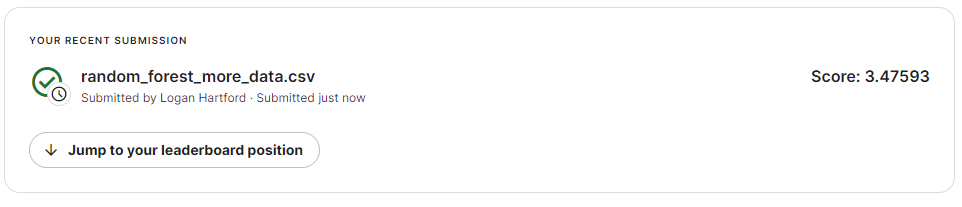
Got a slightly better score but the training went way longer so I think I will try an optimize with the smaller dataset and then move to larger datasets later

In [119]:
# Save the data
save_pickle(path/'10_xs.pkl', xs)
save_pickle(path/'10_y.pkl', y)
save_pickle(path/'10_valid_xs.pkl', valid_xs)
save_pickle(path/'10_test_xs.pkl', test_xs)

In [139]:
# Load the old data
# Save the data
xs = load_pickle(path/'xs.pkl')
y = load_pickle(path/'y.pkl')
valid_xs = load_pickle(path/'valid_xs.pkl')
test_xs = load_pickle(path/'test_xs.pkl')
xs = xs.astype(np.float32)
y = y.astype(np.float32)

In [130]:
m = rf(xs, y)

In [131]:
get_metrics(m, xs, valid_xs)

(4.0338659509248105, 4.242535826408129)

## Data
Now lets take a look at the data a bit closer and see if we can figure anything out, though I have a feeling throwing a big neural net at this is going to be the solution

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


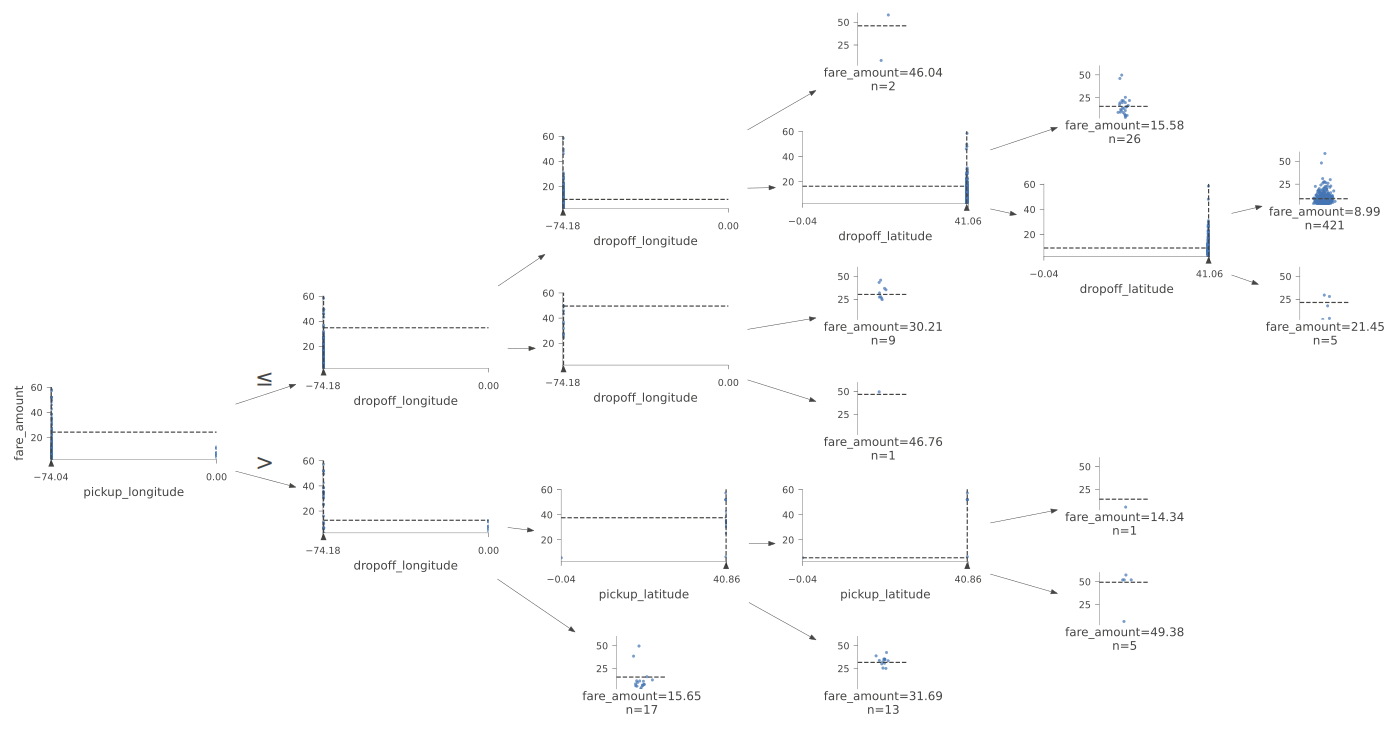

In [136]:
m = DecisionTreeRegressor(max_leaf_nodes=10)
m.fit(xs, y);

samp_idx = np.random.permutation(len(y))[:500]

viz_model=model(m,
                         X_train=xs.iloc[samp_idx],
                         y_train=y.iloc[samp_idx],
                         feature_names=xs.columns,
                         target_name=dep_var)

viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')

There seems to be some outliers in the longitude and latitude data.

In [137]:
get_metrics(m, xs, valid_xs)

(6.830851696228347, 6.29275167497259)

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_box_plot(df, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.show()

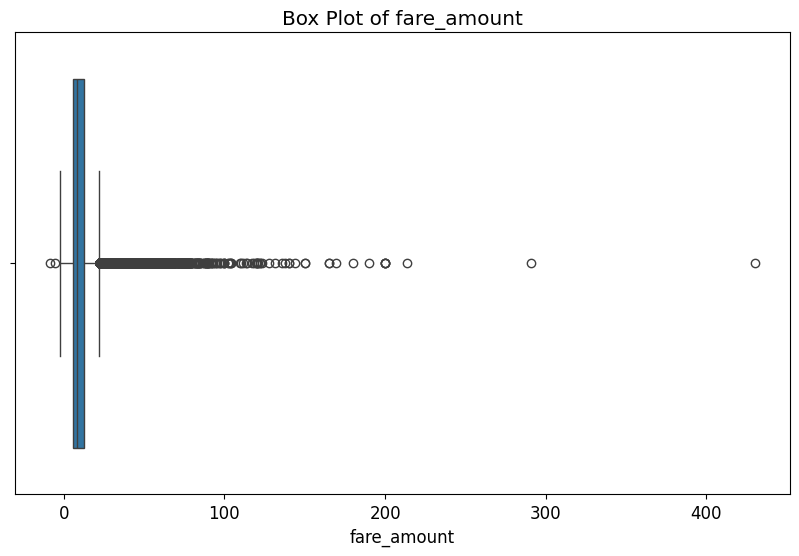

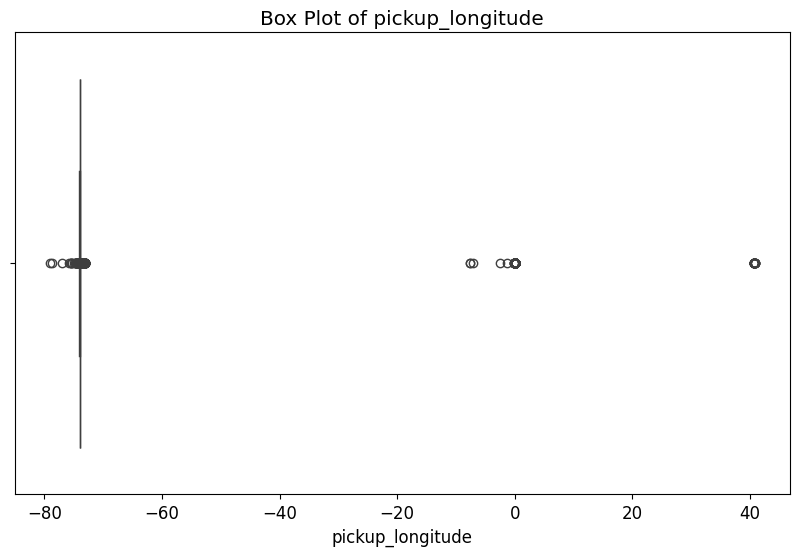

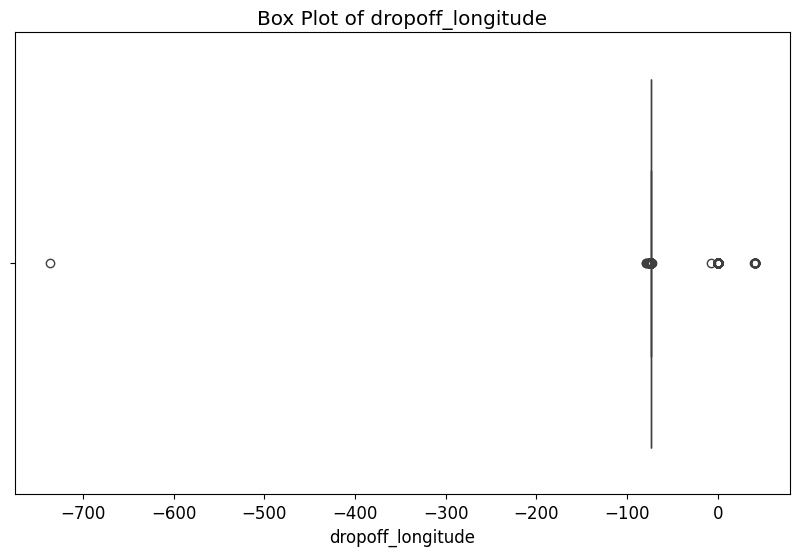

In [154]:
show_box_plot(train_df, "fare_amount")
show_box_plot(xs, "pickup_longitude")
show_box_plot(xs, "dropoff_longitude")

In [147]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers

    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Compute the differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance
xs_dist = xs.copy()
xs_dist['distance'] = haversine(xs_dist['pickup_latitude'], xs_dist['pickup_longitude'],
                           xs_dist['dropoff_latitude'], xs_dist['dropoff_longitude'])

valid_xs_dist = valid_xs.copy()
valid_xs_dist['distance'] = haversine(valid_xs_dist['pickup_latitude'], valid_xs_dist['pickup_longitude'],
                           valid_xs_dist['dropoff_latitude'], valid_xs_dist['dropoff_longitude'])

xs_dist.head()

,key,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetimeYear,pickup_datetimeMonth,pickup_datetimeWeek,pickup_datetimeDay,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeElapsed,distance
11592038,39098.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.983017,40.744919,-73.974319,40.758698,1.0,2011.0,7.0,29.0,18.0,0.0,199.0,1.310989e+09,1.698208
11577551,87787.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.977951,40.788792,-73.983627,40.775284,1.0,2014.0,8.0,34.0,20.0,2.0,232.0,1.408536e+09,1.576075
11579226,92928.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.974747,40.790810,-73.961807,40.779701,3.0,2014.0,12.0,52.0,26.0,4.0,360.0,1.419619e+09,1.646593
11563647,64099.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.982086,40.762634,-73.955544,40.776073,1.0,2013.0,2.0,6.0,7.0,3.0,38.0,1.360278e+09,2.689147
11514119,30456.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.953194,40.788567,-73.971596,40.795498,2.0,2011.0,1.0,1.0,3.0,0.0,3.0,1.294073e+09,1.730760


In [148]:
m_dist = DecisionTreeRegressor(max_leaf_nodes=10)
m_dist.fit(xs_dist, y);

In [149]:
get_metrics(m, xs, valid_xs), get_metrics(m_dist, xs_dist, valid_xs_dist)

((6.830851696228347, 6.29275167497259), (5.522135725937871, 5.052734603999101))

Adding the distance column yeilded significant improvement.

In [150]:
# Save the data
save_pickle(path/'xs_dist.pkl', xs_dist)
save_pickle(path/'valid_xs_dist.pkl', valid_xs_dist)

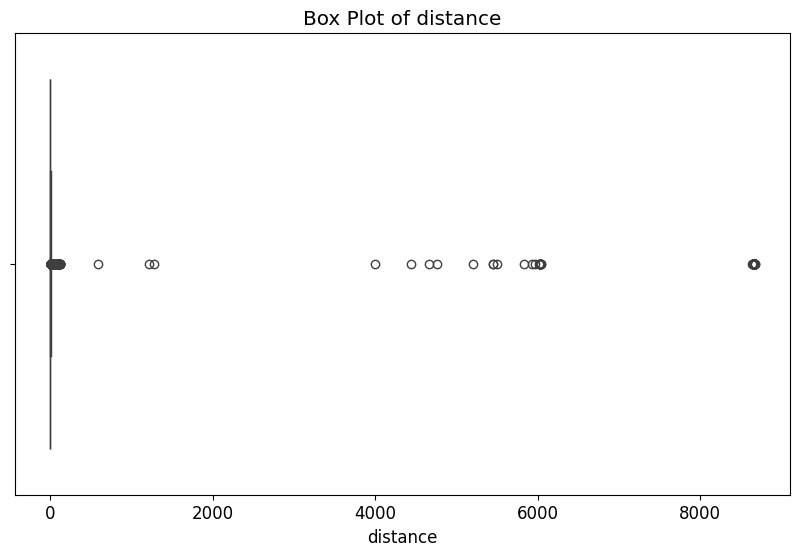

In [156]:
show_box_plot(xs_dist, "distance")

In [162]:
xs_dist[xs_dist['distance'] > 200]

,key,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetimeYear,pickup_datetimeMonth,pickup_datetimeWeek,pickup_datetimeDay,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeElapsed,distance
11520429,60785.0,1.0,1.0,1.0,1.0,1.0,1.0,-74.000710,40.729885,0.000000,0.000000,1.0,2012.0,11.0,47.0,24.0,5.0,329.0,1.353725e+09,8666.978516
11599411,42305.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,-73.979301,40.746101,1.0,2011.0,10.0,40.0,4.0,1.0,277.0,1.317740e+09,8665.537109
11583995,95043.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,-73.989983,40.752586,1.0,2015.0,2.0,8.0,21.0,5.0,52.0,1.424485e+09,8666.555664
11505513,61778.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.849998,40.825523,0.000000,0.000000,1.0,2012.0,12.0,50.0,15.0,5.0,350.0,1.355570e+09,8656.475586
11545538,89417.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,-73.960449,40.778122,1.0,2014.0,9.0,40.0,29.0,0.0,272.0,1.412027e+09,8664.633789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11550723,55720.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.946945,40.780060,-77.716400,30.319572,2.0,2012.0,7.0,30.0,27.0,4.0,209.0,1.343429e+09,1211.770020
11544200,86562.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,-73.986427,40.715801,3.0,2014.0,7.0,29.0,20.0,6.0,201.0,1.405816e+09,8665.507812
11539014,52789.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.977142,40.683765,0.000000,0.000000,1.0,2012.0,5.0,21.0,21.0,0.0,142.0,1.337606e+09,8664.083984
11598127,94143.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,-74.017952,40.706200,1.0,2015.0,1.0,5.0,29.0,3.0,29.0,1.422548e+09,8667.923828


There clearly seems to be some massive outliers in the distances, likely due to incorrect, or coordinates set to 0. Let's try removing these outliers.

In [163]:
xs_short = xs_dist[xs_dist['distance'] < 200]
xs_short

,key,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetimeYear,pickup_datetimeMonth,pickup_datetimeWeek,pickup_datetimeDay,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeElapsed,distance
11592038,39098.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.983017,40.744919,-73.974319,40.758698,1.0,2011.0,7.0,29.0,18.0,0.0,199.0,1.310989e+09,1.698208
11577551,87787.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.977951,40.788792,-73.983627,40.775284,1.0,2014.0,8.0,34.0,20.0,2.0,232.0,1.408536e+09,1.576075
11579226,92928.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.974747,40.790810,-73.961807,40.779701,3.0,2014.0,12.0,52.0,26.0,4.0,360.0,1.419619e+09,1.646593
11563647,64099.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.982086,40.762634,-73.955544,40.776073,1.0,2013.0,2.0,6.0,7.0,3.0,38.0,1.360278e+09,2.689147
11514119,30456.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.953194,40.788567,-73.971596,40.795498,2.0,2011.0,1.0,1.0,3.0,0.0,3.0,1.294073e+09,1.730760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11560594,59153.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.978531,40.777248,-73.951683,40.773693,1.0,2012.0,10.0,42.0,15.0,0.0,289.0,1.350329e+09,2.295163
11515435,23676.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.977211,40.789986,-73.951675,40.782825,1.0,2010.0,7.0,28.0,15.0,3.0,196.0,1.279217e+09,2.292810
11500477,37778.0,1.0,1.0,1.0,1.0,1.0,1.0,-74.009598,40.715157,-74.004501,40.742287,2.0,2011.0,6.0,24.0,17.0,4.0,168.0,1.308347e+09,3.047065
11532348,46090.0,1.0,1.0,1.0,1.0,1.0,1.0,-73.955902,40.779240,-73.965065,40.769691,1.0,2011.0,12.0,52.0,28.0,2.0,362.0,1.325076e+09,1.312013


Now lets see if this has helped remove some of the longitude and latitude outliers

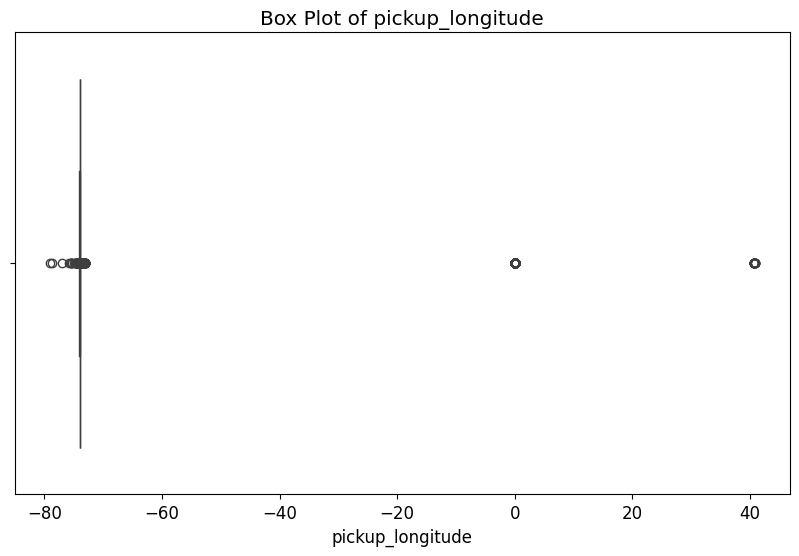

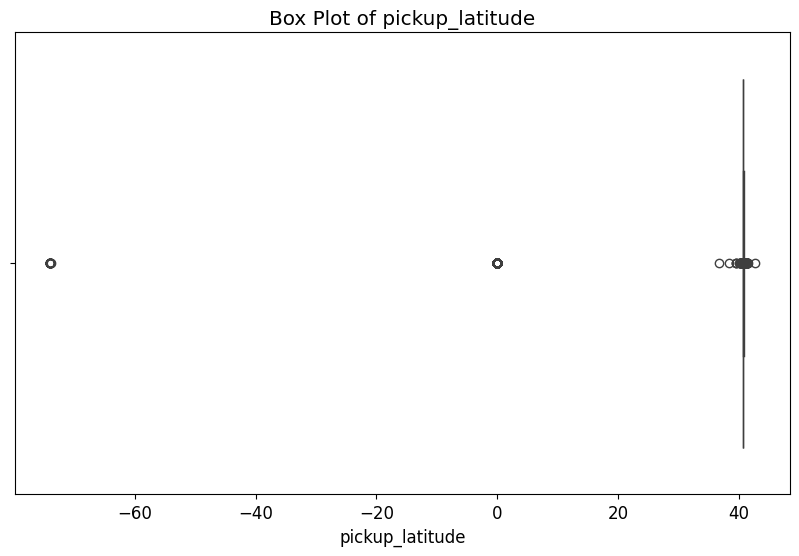

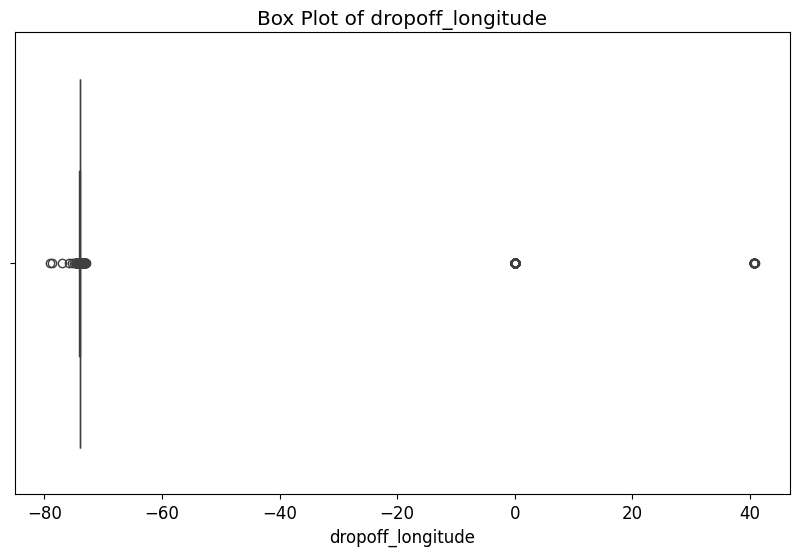

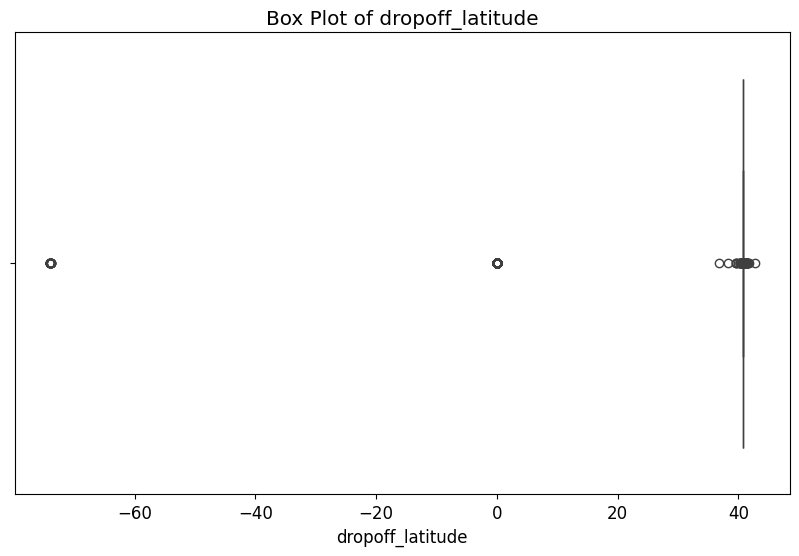

In [165]:
show_box_plot(xs_short, "pickup_longitude")
show_box_plot(xs_short, "pickup_latitude")
show_box_plot(xs_short, "dropoff_longitude")
show_box_plot(xs_short, "dropoff_latitude")

It appears we have a couple of outliers left

In [167]:
xs_short[xs_short["pickup_longitude"] == 0]

,key,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetimeYear,pickup_datetimeMonth,pickup_datetimeWeek,pickup_datetimeDay,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeElapsed,distance
11526219,53250.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,2012.0,6.0,22.0,1.0,4.0,153.0,1.338584e+09,0.0
11570053,78535.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2014.0,1.0,2.0,11.0,5.0,11.0,1.389463e+09,0.0
11587160,28975.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2010.0,11.0,47.0,25.0,3.0,329.0,1.290718e+09,0.0
11580499,90400.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2014.0,10.0,43.0,24.0,4.0,297.0,1.414129e+09,0.0
11598216,15249.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2009.0,12.0,52.0,24.0,3.0,358.0,1.261640e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11541402,94427.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2015.0,2.0,6.0,5.0,3.0,36.0,1.423164e+09,0.0
11542666,82317.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2014.0,4.0,15.0,9.0,2.0,99.0,1.397079e+09,0.0
11540500,51626.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2012.0,4.0,17.0,26.0,3.0,117.0,1.335471e+09,0.0
11535141,34067.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2011.0,3.0,12.0,27.0,6.0,86.0,1.301195e+09,0.0


In [168]:
train_df[train_df["pickup_longitude"] == 0]

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetimeYear,pickup_datetimeMonth,pickup_datetimeWeek,pickup_datetimeDay,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeElapsed
11500012,2015-06-14 00:20:27.0000001,13.00,0.0,0.0,0.0,0.0,2,2015,6,24,14,6,165,False,False,False,False,False,False,1.434241e+09
11500119,2015-04-26 14:23:26.0000004,11.50,0.0,0.0,0.0,0.0,1,2015,4,17,26,6,116,False,False,False,False,False,False,1.430058e+09
11500155,2009-01-17 21:35:48.0000003,26.35,0.0,0.0,0.0,0.0,1,2009,1,3,17,5,17,False,False,False,False,False,False,1.232228e+09
11500159,2013-01-22 06:22:00.00000053,56.80,0.0,0.0,0.0,0.0,1,2013,1,4,22,1,22,False,False,False,False,False,False,1.358836e+09
11500215,2011-03-31 13:16:17.0000002,3.30,0.0,0.0,0.0,0.0,1,2011,3,13,31,3,90,True,False,True,False,False,False,1.301577e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11599950,2010-06-13 04:48:00.00000010,4.10,0.0,0.0,0.0,0.0,2,2010,6,23,13,6,164,False,False,False,False,False,False,1.276404e+09
11599958,2013-05-12 10:54:34.0000001,5.00,0.0,0.0,0.0,0.0,1,2013,5,19,12,6,132,False,False,False,False,False,False,1.368356e+09
11599961,2011-11-13 00:28:00.00000012,16.90,0.0,0.0,0.0,0.0,1,2011,11,45,13,6,317,False,False,False,False,False,False,1.321144e+09
11599977,2010-02-11 08:24:00.00000087,4.90,0.0,0.0,0.0,0.0,1,2010,2,6,11,3,42,False,False,False,False,False,False,1.265877e+09


The outliers for longitude and latitude don't appear to be good predictors for fare prices so we can try removing them, but first lets see where we are at.

In [185]:
train_df['distance'] = haversine(train_df['pickup_latitude'], train_df['pickup_longitude'],
                           train_df['dropoff_latitude'], train_df['dropoff_longitude'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 11500000 to 11599999
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   key                              100000 non-null  object 
 1   fare_amount                      100000 non-null  float64
 2   pickup_longitude                 100000 non-null  float64
 3   pickup_latitude                  100000 non-null  float64
 4   dropoff_longitude                100000 non-null  float64
 5   dropoff_latitude                 100000 non-null  float64
 6   passenger_count                  100000 non-null  int64  
 7   pickup_datetimeYear              100000 non-null  int32  
 8   pickup_datetimeMonth             100000 non-null  int32  
 9   pickup_datetimeWeek              100000 non-null  int32  
 10  pickup_datetimeDay               100000 non-null  int32  
 11  pickup_datetimeDayofweek         100000 non-null  int32 

In [187]:
cont, cat = cont_cat_split(train_df, 1, dep_var=dep_var)
procs = [Categorify, FillMissing]
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs, cat, cont, y_names=dep_var, splits=splits)
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [188]:
short_xs = xs[xs['distance'] < 200]
short_y = y[xs['distance'] < 200]
len(short_xs), len(short_y)

(79824, 79824)

In [189]:
def get_metrics(m, xs, valid_xs, y, valid_y):
    train_preds = m.predict(xs)
    valid_preds = m.predict(valid_xs)
    return rmse(y, train_preds), rmse(valid_y, valid_preds)

In [190]:
short_m = DecisionTreeRegressor(max_leaf_nodes=10)
short_m.fit(short_xs, short_y);

In [195]:
# Load the old data
xs_base = load_pickle(path/'xs.pkl')
valid_xs_base = load_pickle(path/'valid_xs.pkl')
xs_base = xs_base.astype(np.float32)
m_base = DecisionTreeRegressor(max_leaf_nodes=10)
m_base.fit(xs_base, y);

In [196]:
get_metrics(m_base, xs_base, valid_xs_base, y, valid_y), get_metrics(short_m, short_xs, valid_xs, short_y, valid_y)

((9.90474070008689, 9.593944537864141), (5.44258509177195, 5.367841025621772))

It looks like our baseline is much worse than when we started but I don't think I was carefule enough about not contaminating the data.

This should be the actual baseline since I loaded the data from before any pre-processing starting.

TODO: run pipline from start with fresh kernel and make sure everything makes sense.

I'm curious to see if any of the pickup and drop off outliers still exist and what the effect of removing them will be.

In [200]:
avg_d_long = short_xs["dropoff_longitude"].mean()
avg_d_lat = short_xs["dropoff_latitude"].mean()
avg_p_long = short_xs["pickup_longitude"].mean()
avg_p_lat = short_xs["pickup_latitude"].mean()

In [218]:
out_xs = short_xs.copy()
print(len(out_xs))
delta = 2
mask = (out_xs["dropoff_longitude"] > (avg_d_long - delta)) & (out_xs["dropoff_longitude"] < (avg_d_long + delta))
out_xs = out_xs[mask]
out_y = short_y.copy()
out_y = out_y[mask]
print(len(out_xs)), print(len(out_y))

79824
78295
78295


(None, None)

In [219]:
mask = (out_xs["dropoff_latitude"] > (avg_d_lat - delta)) & (out_xs["dropoff_latitude"] < (avg_d_lat + delta))
out_xs = out_xs[mask]
out_y = out_y[mask]
mask = (out_xs["pickup_longitude"] > (avg_p_long - delta)) & (out_xs["pickup_longitude"] < (avg_p_long + delta))
out_xs = out_xs[mask]
out_y = out_y[mask]
mask = (out_xs["pickup_latitude"] > (avg_p_lat - delta)) & (out_xs["pickup_latitude"] < (avg_p_lat + delta))
out_xs = out_xs[mask]
out_y = out_y[mask]
print(len(out_xs)), print(len(out_y))

78292
78292


(None, None)

In [220]:
out_m = DecisionTreeRegressor(max_leaf_nodes=10)
out_m.fit(out_xs, out_y);
get_metrics(m_base, xs_base, valid_xs_base, y, valid_y), get_metrics(out_m, out_xs, valid_xs, out_y, valid_y)

((9.90474070008689, 9.593944537864141), (5.255917112140085, 5.431352237167873))

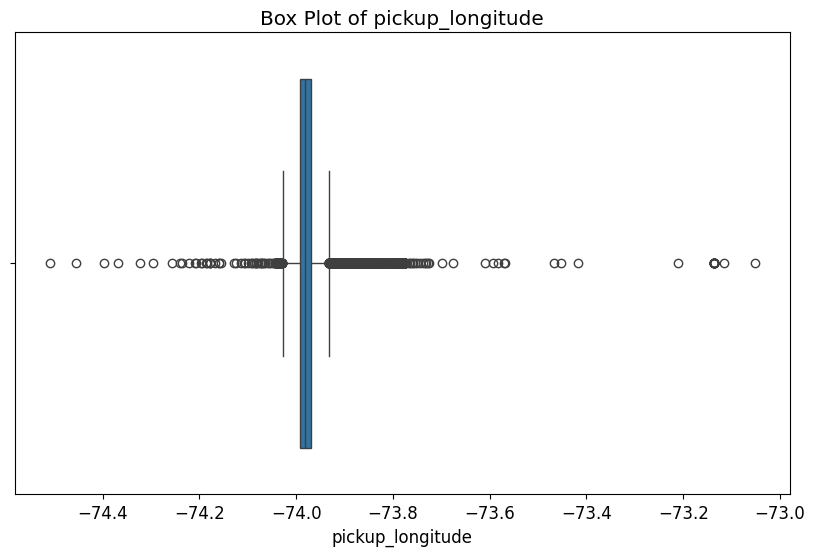

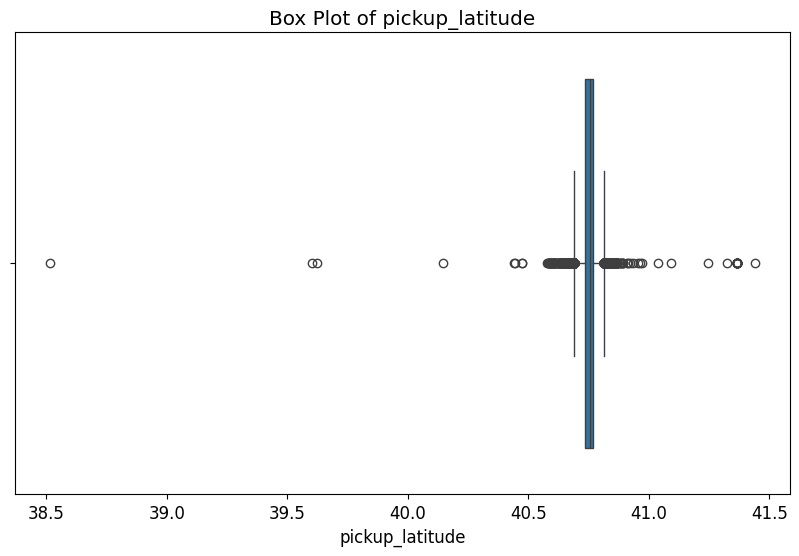

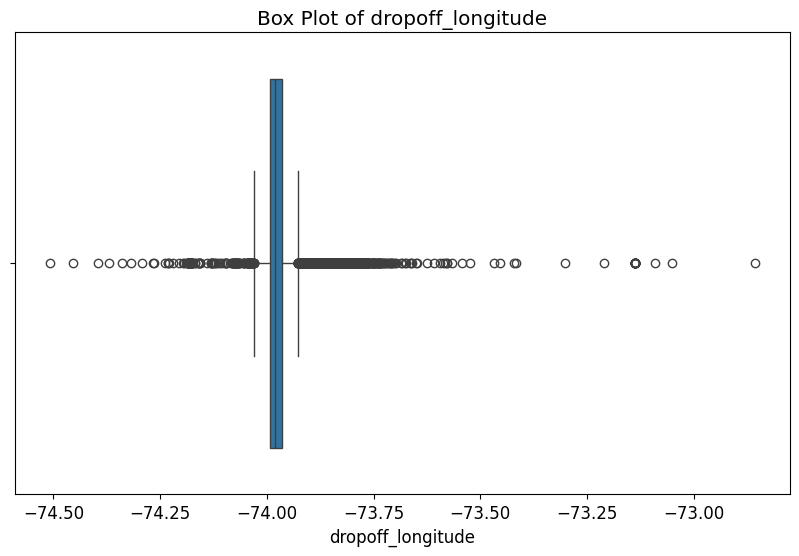

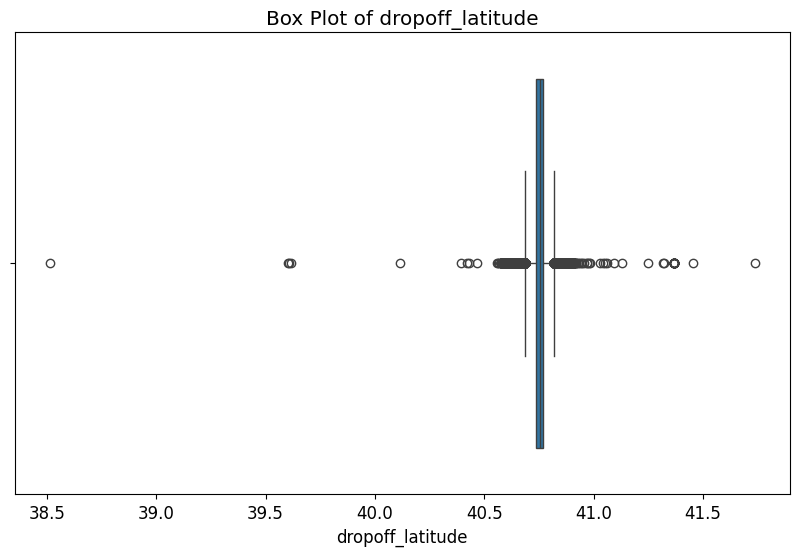

In [221]:
show_box_plot(out_xs, "pickup_longitude")
show_box_plot(out_xs, "pickup_latitude")
show_box_plot(out_xs, "dropoff_longitude")
show_box_plot(out_xs, "dropoff_latitude")

It looks like both removing the distacne and location outliers slightly increase our performance on the test set, but decreased our performance on the validation set.

We should look at the test set and see if it appears to contain the distance and location outliers

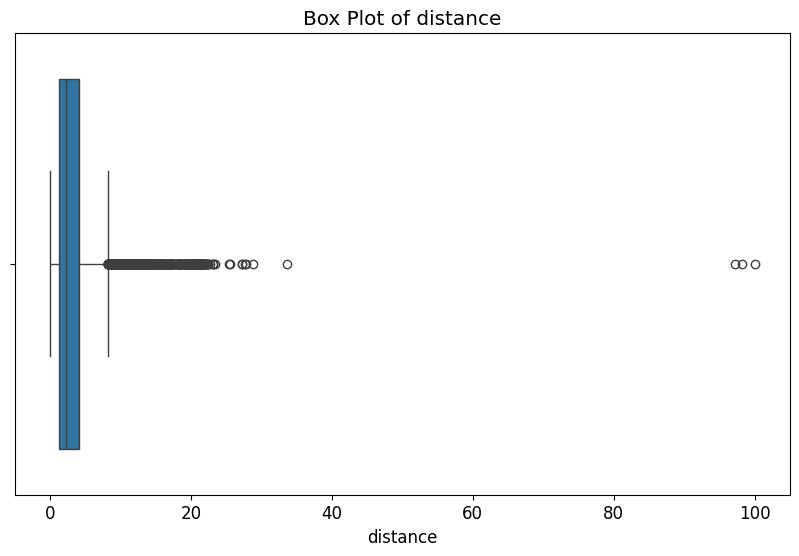

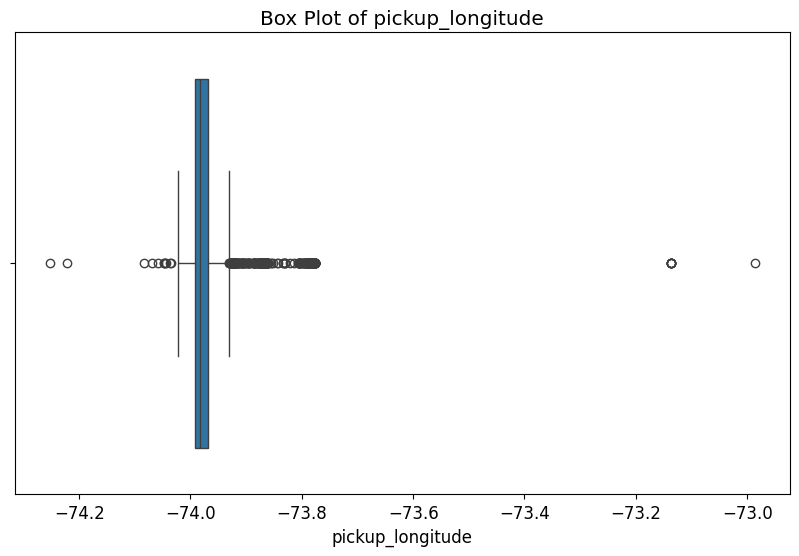

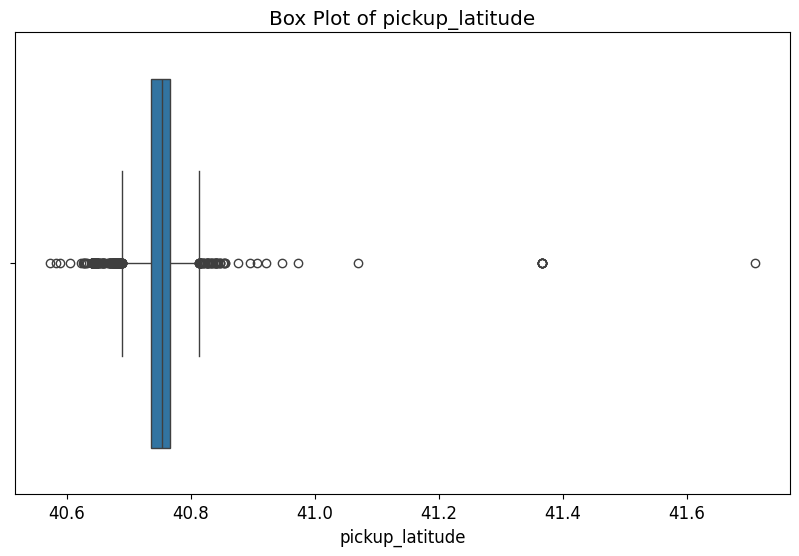

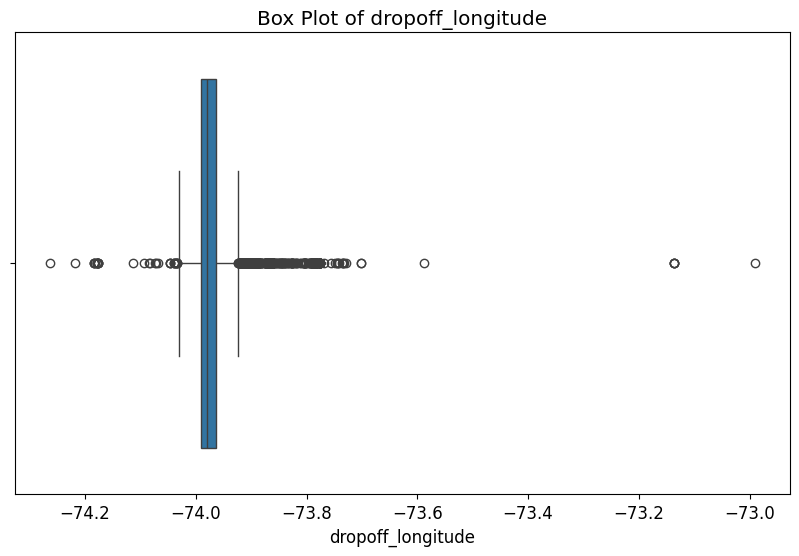

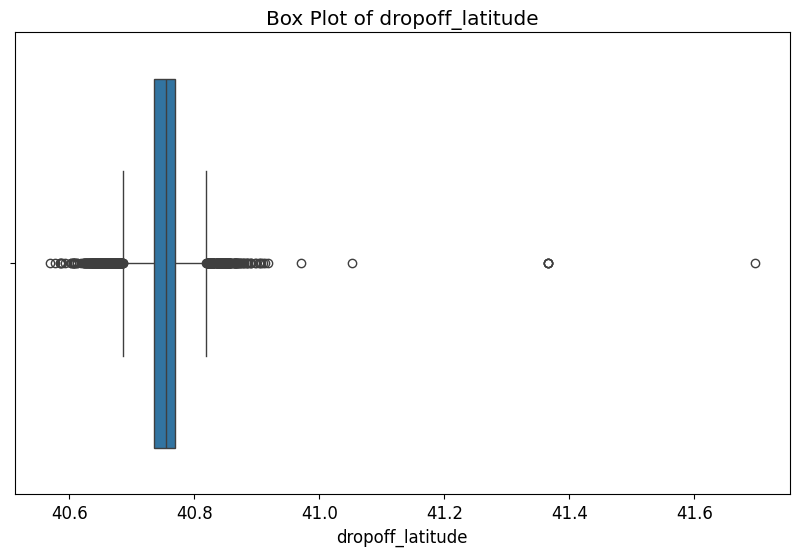

In [223]:
test_xs = load_pickle(path/'test_xs.pkl')
t_test_xs = test_xs.copy()
t_test_xs['distance'] = haversine(t_test_xs['pickup_latitude'], t_test_xs['pickup_longitude'],
                           t_test_xs['dropoff_latitude'], t_test_xs['dropoff_longitude'])
show_box_plot(t_test_xs, "distance")
show_box_plot(t_test_xs, "pickup_longitude")
show_box_plot(t_test_xs, "pickup_latitude")
show_box_plot(t_test_xs, "dropoff_longitude")
show_box_plot(t_test_xs, "dropoff_latitude")

The test data does not contain the large outliers in distance and location, so I suspect our model would do better on the test set than on the validation set.

Lets generate a submission with our current tree to test that theory, and then lets generate a random forest and see where we are at.

In [224]:
generate_submission(out_m, t_test_xs, "tree_clean_data")

100%|█████████████████████████| 329k/329k [00:00<00:00, 477kB/s]


Successfully submitted to New York City Taxi Fare Prediction

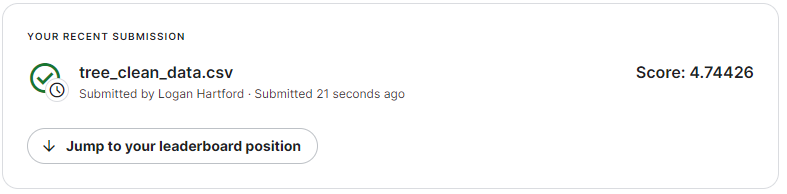

Our score on the test set was much better, I will proceed with removing outliers from the data.

Now lets try a random forest.

In [226]:
rf_m = rf(out_xs, out_y)
get_metrics(m_base, xs_base, valid_xs_base, y, valid_y), get_metrics(rf_m, out_xs, valid_xs, out_y, valid_y)

((9.90474070008689, 9.593944537864141),
 (3.6645485409844474, 5.643384782761839))

In [227]:
generate_submission(rf_m, t_test_xs, "forest_clean_data")

100%|█████████████████████████| 328k/328k [00:00<00:00, 502kB/s]


Successfully submitted to New York City Taxi Fare Prediction

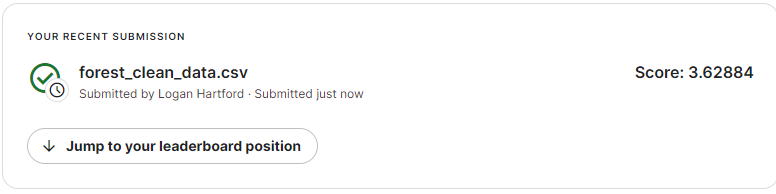

Our forrest did about as well on the test set as on the training set, but much better than on the validation set. Doing forward, I will remove the outliers from the validation set as well to give a better indicator of test set performance.

Our random forest score improved from last time but did not surpase the rf that was trained on more data.

What else do we want to do:
* Re-inspect the data using dtreeviz and see if anything else obvious shows up
* Take a look at feature importance
* Take a look at redundant features
* Take a look at partial dependance
* Use tree interpreter
* Look for out of domain data
* Apply a neural network
* Apply gradient boosting
* Ensemble
* Try training multiple forests on multiple chunks and then ensembling them vs training a single forest on all the trunks
* See if the number of tree's matters in this comparasion
* Take the best performing technique and train it on all the data

I imagine that to do well on this dataset, you would also need to bring in traffic data and maybe some information about the pickup and dropoff locations but I'm just interested in precticing what I learned in lesson 6 so I'll stick to the list above.

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


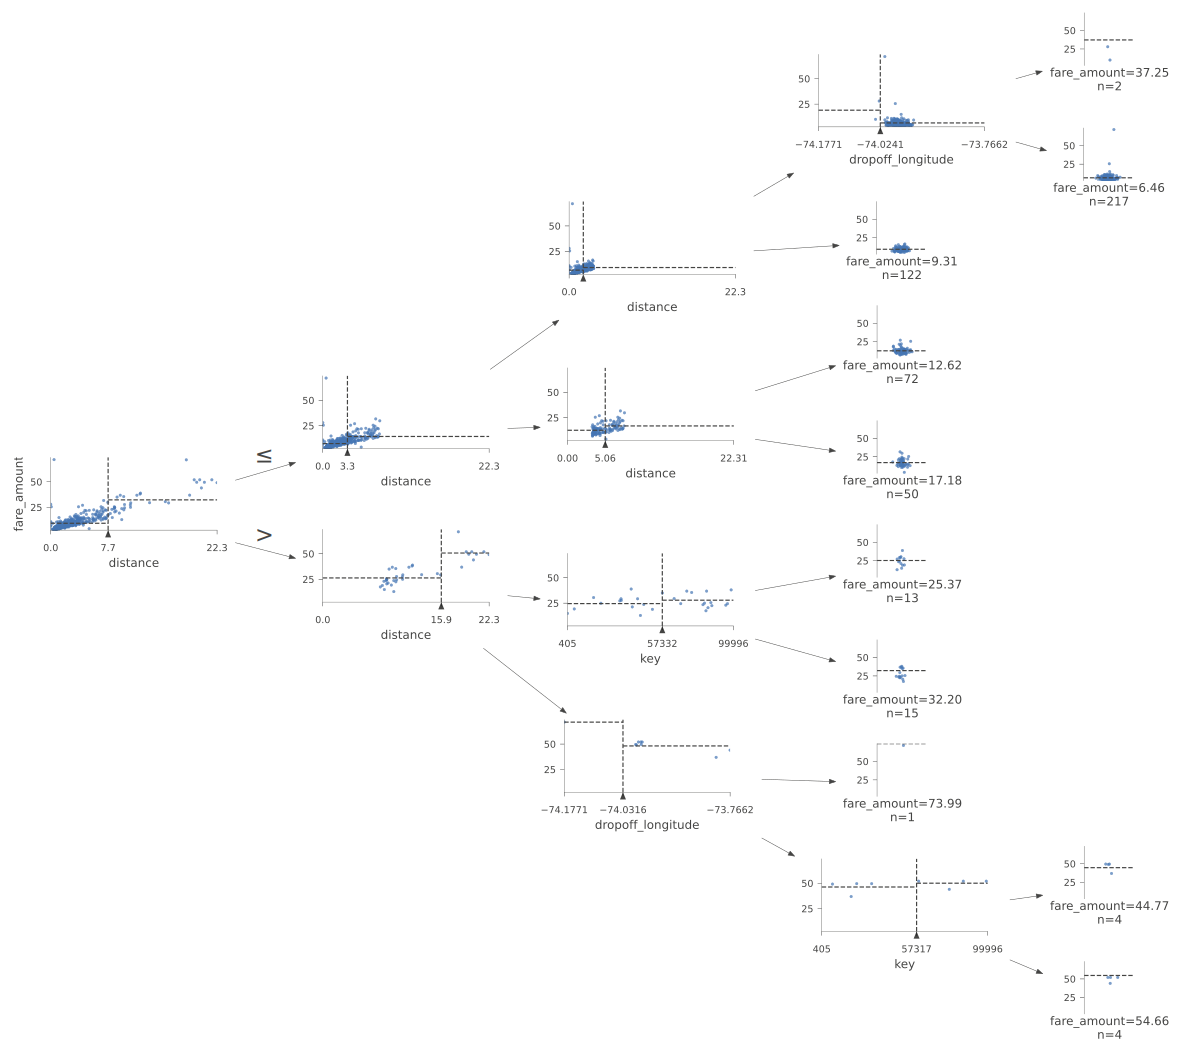

In [229]:
samp_idx = np.random.permutation(len(out_y))[:500]

viz_model=model(out_m,
                         X_train=out_xs.iloc[samp_idx],
                         y_train=out_y.iloc[samp_idx],
                         feature_names=out_xs.columns,
                         target_name=dep_var)

viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')

Nothing is jumping out at me here.

Need to fix my validation set though.

In [279]:
def add_distance(x):
    return haversine(x['pickup_latitude'], x['pickup_longitude'],
                           x['dropoff_latitude'], x['dropoff_longitude'])
    
def remove_outliers(x, y):
    cols = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]
    delta = 2
    ret_x = x.copy()
    ret_y = y.copy()
    mask = ret_x[ret_x["distance"] < 200]
    ret_x = ret_x[mask]
    ret_y = ret_y[mask]
    for col in cols:
        avg = ret_x[col].mean()
        mask = (ret_x[col] > (avg - delta)) & (ret_x[col] < (avg + delta))
        ret_x = ret_x[mask]
        ret_y = ret_y[mask]
    return ret_x, ret_y

In [249]:
out_valid_xs, out_valid_y = remove_outliers(valid_xs, valid_y)

In [250]:
print(len(valid_xs)), print(len(valid_y))
print(len(out_valid_xs)), print(len(out_valid_y))

20000
20000
19557
19557


(None, None)

In [251]:
get_metrics(m_base, xs_base, valid_xs_base, y, valid_y), get_metrics(rf_m, out_xs, out_valid_xs, out_y, out_valid_y)

((9.90474070008689, 9.593944537864141),
 (3.6645485409844474, 3.828636231128038))

This is a better reflection of our perfomance on the test set. Also, I forgot that the validation set is just suppossed to check to see if the model generalizes, it is not necissarily meant to reamin raw data or be manipulated to look like the training data.

### Feature Importance

In [230]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(rf_m, out_xs)
fi

,cols,imp
19,distance,0.604332
7,pickup_longitude,0.143626
9,dropoff_longitude,0.105020
10,dropoff_latitude,0.049637
8,pickup_latitude,0.030332
0,key,0.019305
18,pickup_datetimeElapsed,0.019073
15,pickup_datetimeDay,0.006478
17,pickup_datetimeDayofyear,0.006051
16,pickup_datetimeDayofweek,0.004403


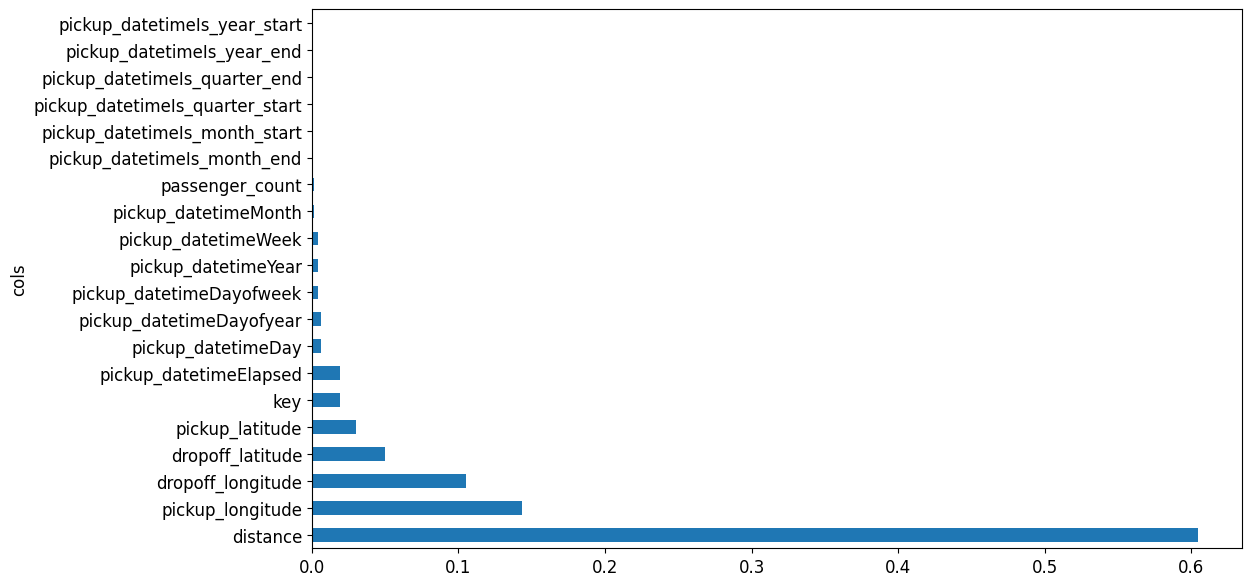

In [231]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi);

A lot of the data meta data appears to be useless, lets get rid of the unimportant columns.

In [261]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

9

In [265]:
xs_imp = out_xs[to_keep]
valid_xs_imp = out_valid_xs[to_keep]
m = rf(xs_imp, out_y)

In [266]:
len(xs_imp),len(valid_xs_imp),len(out_y),len(out_valid_y),

(78292, 19557, 78292, 19557)

In [267]:
get_metrics(m_base, xs_base, valid_xs_base, y, valid_y), get_metrics(m, xs_imp, valid_xs_imp, out_y, out_valid_y)

((9.90474070008689, 9.593944537864141),
 (3.6876273729664666, 3.8026966325521983))

No real change but the model is simpler.

### Redunant Features

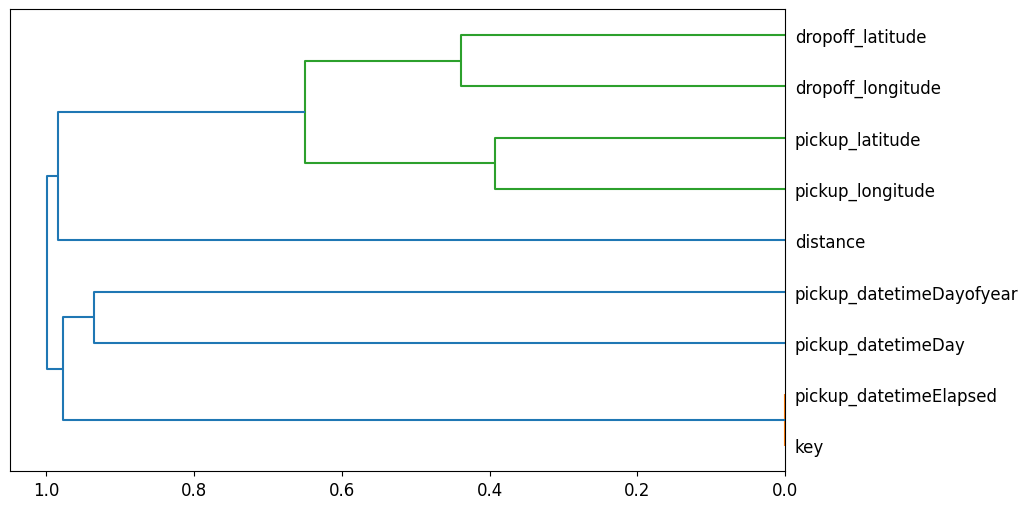

In [268]:
cluster_columns(xs_imp)

There doesn't seem to be any obiously reducnant columns. We could probably remove 'key', but we need it for submission so I don't think it's worth it.

### Partial Dependance

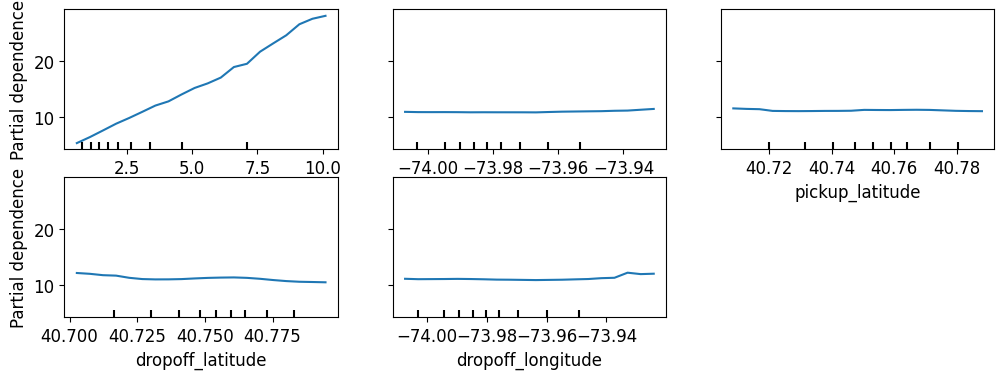

In [270]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features = ["distance", "pickup_longitude", "pickup_latitude", "dropoff_latitude", "dropoff_longitude"]

fig, ax = plt.subplots(figsize=(12, 4))
display = PartialDependenceDisplay.from_estimator(m, valid_xs_imp, features, ax=ax, grid_resolution=20)
		
plt.show()

This shows what I would expect, the predicted price is strongly correlated with distance but is agnostic to the pickup and dropoff locations.

### Tree Interpreter

In [271]:
!pip install treeinterpreter
!pip install waterfallcharts

  Preparing metadata (setup.py) ... done
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3388 sha256=00e486a047c4fc12cb542d2847eb49dd41063d26e18095399a0a440324281c7d
  Stored in directory: /root/.cache/pip/wheels/49/9a/ff/ec03fce8e52feb9578e6d919014384cd15a7f1a2d90f56fce9
Successfully built waterfallcharts


In [272]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

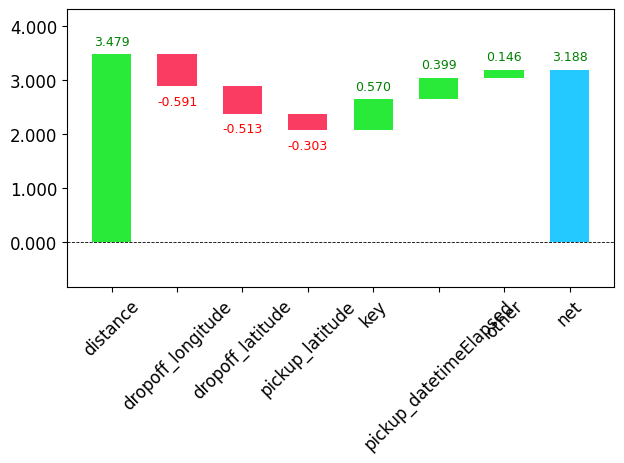

In [276]:
row = xs_imp.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m, row.values)
prediction[0], bias[0], contributions[0].sum()
waterfall(xs_imp.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

### Out of Domain Data
We'll put the training data and the test data into a single dataset and use a a rf to try and predict which set each row came from. Then we can use feature importance to see if there are any major differences between the two. 

In [307]:
train_df = chunk_list[random.randint(1, len(chunk_list))]
test_df = pd.read_csv("new-york-city-taxi-fare-prediction/test.csv")

In [417]:
def remove_outliers_df(df):
    cols = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]
    delta = 2
    ret_df = df.copy()
    mask = (ret_df["distance"] < 200)
    ret_df = ret_df[mask]
    for col in cols:
        avg = ret_df[col].mean()
        mask = (ret_df[col] > (avg - delta)) & (ret_df[col] < (avg + delta))
        ret_df = ret_df[mask]
    return ret_df

def process_data(df, train_data=True):
    ret_df = df.copy()
    ret_df = add_datepart(ret_df, 'pickup_datetime')
    ret_df["distance"] = add_distance(ret_df)
    if train_data:
        ret_df = ret_df[to_keep.to_list() + [dep_var]]
        ret_df = remove_outliers_df(ret_df)
    else:
        ret_df = ret_df[to_keep]
    return ret_df
    

In [310]:
train_df = process_data(train_df, train_data=True)
test_df = process_data(test_df, train_data=False)

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [315]:
df_dom = pd.concat([train_df, test_df])
is_valid = np.array([0]*len(train_df) + [1]*len(test_df))
df_dom.info(), len(is_valid)

<class 'pandas.core.frame.DataFrame'>
Index: 107893 entries, 23400000 to 9913
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   distance                  107893 non-null  float64
 1   pickup_longitude          107893 non-null  float64
 2   dropoff_longitude         107893 non-null  float64
 3   dropoff_latitude          107893 non-null  float64
 4   pickup_latitude           107893 non-null  float64
 5   key                       107893 non-null  object 
 6   pickup_datetimeElapsed    107893 non-null  float64
 7   pickup_datetimeDay        107893 non-null  int32  
 8   pickup_datetimeDayofyear  107893 non-null  int32  
dtypes: float64(6), int32(2), object(1)
memory usage: 7.4+ MB


(None, 107893)

In [327]:
cont, cat = cont_cat_split(df_dom, 1)
procs = [Categorify, FillMissing]
splits = RandomSplitter(valid_pct=0.2)(range_of(df_dom))
to = TabularPandas(df_dom, procs, cat, cont)
dom_tb = to.train.xs

In [329]:
m = rf(dom_tb, is_valid)
rf_feat_importance(m, df_dom)

,cols,imp
0,distance,0.301488
6,pickup_datetimeElapsed,0.293071
8,pickup_datetimeDayofyear,0.124913
7,pickup_datetimeDay,0.080987
3,dropoff_latitude,0.040679
5,key,0.040250
2,dropoff_longitude,0.039804
4,pickup_latitude,0.039800
1,pickup_longitude,0.039008


From this it looks like the disance varies a bit from the training data to the test data, however, this is not a column we can afford to remove since it is our best fare predictor.

## Neural Network

In [342]:
df_nn = chunk_list[random.randint(1, len(chunk_list))]
df_nn = process_data(df_nn)
df_nn.info()

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


<class 'pandas.core.frame.DataFrame'>
Index: 97933 entries, 23900000 to 23999999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   distance                  97933 non-null  float64
 1   pickup_longitude          97933 non-null  float64
 2   dropoff_longitude         97933 non-null  float64
 3   dropoff_latitude          97933 non-null  float64
 4   pickup_latitude           97933 non-null  float64
 5   key                       97933 non-null  object 
 6   pickup_datetimeElapsed    97933 non-null  float64
 7   pickup_datetimeDay        97933 non-null  int32  
 8   pickup_datetimeDayofyear  97933 non-null  int32  
 9   fare_amount               97933 non-null  float64
dtypes: float64(7), int32(2), object(1)
memory usage: 7.5+ MB


In [344]:
cont_nn,cat_nn = cont_cat_split(df_nn, max_card=9000, dep_var=dep_var)
procs_nn = [Categorify, FillMissing, Normalize]
splits = RandomSplitter(valid_pct=0.2)(range_of(df_nn))
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [345]:
y = to_nn.train.y
y.min(),y.max()

(-3.5, 348.08)

Interestingly it looks like we have some negative fare_amounts which doesn't make sense, I will try training a forest with and without these entries and see what the impact is

In [356]:
mask = out_y > 0
mask

11502246    True
11518056    True
11551465    True
11598142    True
11505362    True
            ... 
11539374    True
11508041    True
11522927    True
11500265    True
11594773    True
Name: fare_amount, Length: 78292, dtype: bool

In [357]:
mask = out_y > 0
xs_gz = xs_imp[mask]
out_y_gz = out_y[mask]

mask = out_valid_y > 0
valid_xs_gz = valid_xs_imp[mask]
out_valid_y_gz = out_valid_y[mask]

In [362]:
len(out_y), len(out_y_gz)

(78292, 78288)

In [358]:
m = rf(xs_gz, out_y_gz)

In [360]:
get_metrics(m, xs_gz, valid_xs_gz, out_y_gz, out_valid_y_gz)aa

(3.678886002653454, 3.805863816614595)

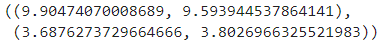

In [365]:
generate_submission(m, t_test_xs[to_keep], "forest_no_neg")

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
100%|█████████████████████████| 328k/328k [00:00<00:00, 527kB/s]


Successfully submitted to New York City Taxi Fare Prediction

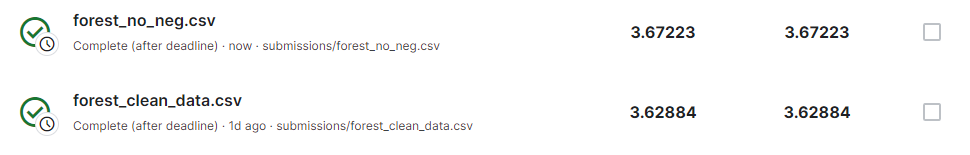
Wosre performance overall, will leave them in.

In [382]:
def rmse_torch(preds, targets):
    return torch.sqrt(F.mse_loss(preds, targets))

dls = to_nn.dataloaders(1024)
learn = tabular_learner(dls, y_range=(-4, 350), layers=[200,100],
                        n_out=1, loss_func=rmse_torch)

SuggestedLRs(valley=0.0030199517495930195)

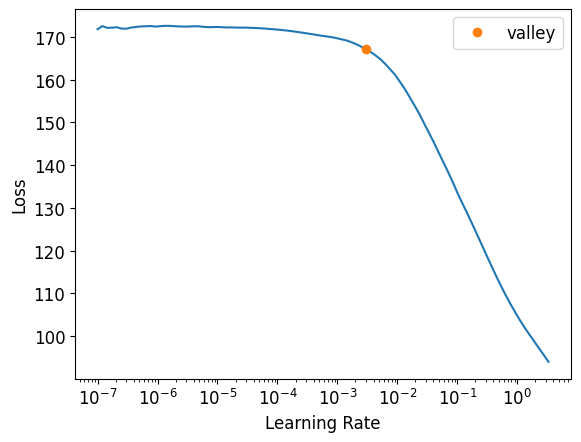

In [379]:
learn.lr_find()

In [383]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,104.372940,54.057732,00:01
1,36.747047,8.382084,00:01
2,13.326333,5.682792,00:01
3,7.391368,4.994070,00:01
4,5.331424,5.412486,00:01
5,4.957490,5.620412,00:01
6,4.499820,5.157058,00:01
7,3.729175,5.028599,00:01
8,3.028319,5.045252,00:01
9,2.723696,5.005327,00:01


In [423]:
def generate_nn_submission(learn, test_df, filename):
    to_test = learn.dls.test_dl(test_df)
    preds, _ = learn.get_preds(dl=to_test)
    test_preds = preds.numpy().flatten().round(2)
    submission = pd.DataFrame({
        'key': test_df['key'],
        'fare_amount': test_preds
    })
    if not filename.endswith(".csv"):
        filename += ".csv"
    submission.to_csv(filename, index=False)
    return kaggle.api.competition_submit(file_name=filename, message=filename, competition='new-york-city-taxi-fare-prediction')


In [424]:
test_df = pd.read_csv("new-york-city-taxi-fare-prediction/test.csv")
test_df_proc = process_data(test_df, train_data=False)

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [425]:
generate_nn_submission(learn, test_df_proc, "nn_2")

100%|█████████████████████████| 328k/328k [00:00<00:00, 515kB/s]


Successfully submitted to New York City Taxi Fare Prediction

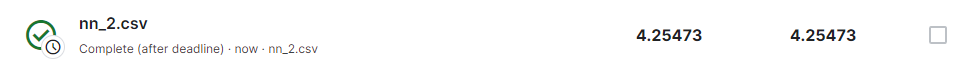

Pretty shit honestly. I have a feeling that theres just not enough data to get the most out of the nn. We'll see how it does on the whole dataset